<a href="https://colab.research.google.com/github/greygrease/Project-FoodNet/blob/main/FoodNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check GPU

To use mixed precision training we need access to Tesla T4

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f1a358dc-c264-940a-b5e7-0ca6b1cb356e)


In [ ]:
!pip install tensorflow==2.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [ ]:
# Use TensorFlow datasets
import tensorflow_datasets as tfds

In [ ]:
# Get all tensorflow datasets
datasets_list = tfds.list_builders()

import pandas as pd
pd.DataFrame(datasets_list)

,0
0,abstract_reasoning
1,accentdb
2,aeslc
3,aflw2k3d
4,ag_news_subset
...,...
1103,kubric:nerf_synthetic_frames
1104,kubric:nerf_synthetic_scenes
1105,kubric:shapenet_pretraining
1106,robotics:mt_opt_rlds


In [ ]:
# Check if our dataset is in the datasets_list
'food101' in datasets_list

True

In [ ]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name ='food101',
                                             split=['train', 'validation'],
                                             shuffle_files= True,
                                             as_supervised=True,   # Data gets returned in tuple format (data, label)
                                             with_info=True)

In [ ]:
# Features of Food101
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [ ]:
# Get class_names
class_names = ds_info.features['label'].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

## Exploring the Food101 dataset
To Find:
*   Shape of our input data
*   Datatype of our input data
*   Class names



In [ ]:
# Take one smaple of the train data
train_sample = train_data.take(1)

In [ ]:
train_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample

for image, label in train_sample:
  print(f'''
  Image shape:{image.shape}

  Image dtype:{image.dtype}

  Class of the sample:{label}

  Class name: {class_names[label.numpy()]} ''')


  Image shape:(384, 512, 3) 
  
  Image dtype:<dtype: 'uint8'>
            
  Class of the sample:70
        
  Class name: pad_thai 


In [ ]:
# What does our image tensor from our dataset look like  ?
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[230, 229, 183],
        [231, 230, 184],
        [232, 231, 183],
        ...,
        [232, 233, 202],
        [229, 234, 204],
        [229, 236, 205]],

       [[228, 227, 179],
        [227, 226, 178],
        [226, 226, 176],
        ...,
        [234, 235, 204],
        [232, 237, 207],
        [234, 241, 210]],

       [[229, 229, 175],
        [229, 229, 175],
        [227, 227, 175],
        ...,
        [233, 234, 202],
        [232, 237, 205],
        [235, 242, 209]],

       ...,

       [[119,  97,  58],
        [131, 109,  70],
        [131, 109,  70],
        ...,
        [239, 241, 220],
        [238, 240, 219],
        [238, 240, 219]],

       [[120,  98,  61],
        [133, 111,  74],
        [135, 113,  76],
        ...,
        [240, 242, 221],
        [240, 242, 221],
        [240, 242, 221]],

       [[136, 114,  77],
        [135, 113,  76],
        [129, 107,  70],
        ...,
        [243, 245, 22

In [ ]:
# Min and Max value of our image tensor
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from the Dataset

(-0.5, 511.5, 383.5, -0.5)

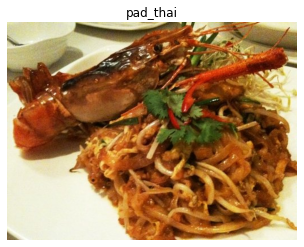

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create preprocessing functions for our data

Neural Netowrks perform best when data is batched and normalised.

What we know about out data:
*   Our data is `uint8` type
*   Consist of tensors of different sizes
*   Not scaled

Models perform well:

*   When data is of type `float32` (or for mixed precision `float16` and `float32`)

*   Tensorflow prefers all of the data in a batch to be the same size

*   Scaled (values b/w 0 and 1)


We are going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data as they have rescaling built in

In [ ]:
# Make a function for preprocessing Images

def preprocess_img(img, label, img_shape = 224):

  image = tf.image.resize(img, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label            # returns (float32_Image, label). tf.cast Converts the Tensors into a specific type.

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f'Image before preprcessing:\n {image[:2]}...\nShape:{image.shape}\nDataType:{image.dtype} ')
print(f'\nImage after preprocessing:\n {preprocessed_img[:2]}...\nShape:{preprocessed_img.shape}\nDataType:{preprocessed_img.dtype}')

Image before preprcessing:
 [[[230 229 183]
  [231 230 184]
  [232 231 183]
  ...
  [232 233 202]
  [229 234 204]
  [229 236 205]]

 [[228 227 179]
  [227 226 178]
  [226 226 176]
  ...
  [234 235 204]
  [232 237 207]
  [234 241 210]]]...
Shape:(384, 512, 3)
DataType:<dtype: 'uint8'> 

Image after preprocessing:
 [[[229.46939 228.46939 181.7551 ]
  [229.59184 228.94897 180.2347 ]
  [224.14796 224.14796 171.71939]
  ...
  [238.21933 231.07143 200.37251]
  [237.02545 233.38266 204.23978]
  [230.32655 236.04091 205.68373]]

 [[228.80103 228.87245 174.58673]
  [225.95409 225.95918 173.80103]
  [226.64795 226.64795 174.21939]
  ...
  [238.41322 232.41322 199.95409]
  [235.8571  233.14287 202.07143]
  [233.04602 238.76038 206.4032 ]]]...
Shape:(224, 224, 3)
DataType:<dtype: 'float32'>


## Batch and prepare datasets


**Note**: Since Efficientnets have rescaling layers built in there is no need to rescale our data

In [ ]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Since our train_data is an Option_dataset which uses tf.data API, we can use the map method to map a certain function

In [ ]:
# Map preprocessing function to training data  (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)

# Shuffle trained data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size = tf.data.AUTOTUNE) # buffer_size mean how many elements to shuffle at a single time


In [ ]:
# Map preprocessing function to test data  (and parallelize)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size = tf.data.AUTOTUNE)


Map function to dataset. Shuffle the data in the dataset and batch then together and make ssure to prepare new batches (prefetch) whilst the model is looking through the current batch.


In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Setup mixed precision

Mixed precision uses a combination of float32 and float16 datatypes to speed up model performance


In [ ]:
# Turn on mixed precision training

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


## Model 1 (Feature Extractor)

Build and Compile Feature Extractor

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
m1_feature_extractor = tf.keras.Model(inputs, outputs)

# Compile the model
m1_feature_extractor.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

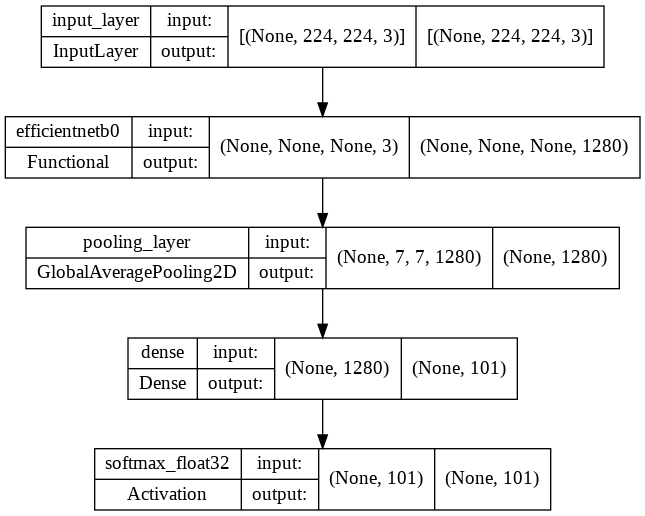

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(m1_feature_extractor, show_shapes = True)

## Checking layer dtype policy

In [ ]:
# Check the dype_poilicy attributes of layers (to check if our model is using mixed precision)
for layer in m1_feature_extractor.layers:
  print(f'{layer.name} is Trainable {layer.trainable} Layers Datatype: {layer.dtype} Layer Policy Dtype: {layer.dtype_policy}')

input_layer is Trainable True Layers Datatype: float32 Layer Policy Dtype: <Policy "float32">
efficientnetb0 is Trainable False Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_float16">
pooling_layer is Trainable True Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_float16">
dense is Trainable True Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_float16">
softmax_float32 is Trainable True Layers Datatype: float32 Layer Policy Dtype: <Policy "float32">


In [ ]:
for layer in base_model.layers[:20]:
  print(f'{layer.name} is Trainable {layer.trainable} Layers Datatype: {layer.dtype} Layer Policy Dtype: {layer.dtype_policy}')

input_1 is Trainable False Layers Datatype: float32 Layer Policy Dtype: <Policy "float32">
rescaling is Trainable False Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_float16">
normalization is Trainable False Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_float16">
stem_conv_pad is Trainable False Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_float16">
stem_conv is Trainable False Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_float16">
stem_bn is Trainable False Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_float16">
stem_activation is Trainable False Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_float16">
block1a_dwconv is Trainable False Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_float16">
block1a_bn is Trainable False Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_float16">
block1a_activation is Trainable False Layers Datatype: float32 Layer Policy Dtype: <Policy "mixed_f

## Fit the feature extraction model

Steps in Feature Extraction:
*   Bulid a feature extraction model
*   Fine tune some of the frozen layers

In [ ]:
# Fit the feature extraction model with callback

h1_FE = m1_feature_extractor.fit(train_data,
                       epochs=3,
                       steps_per_epoch=(len(train_data)),
                       validation_data = test_data,
                       validation_steps =int(0.15 * len(test_data)))

Epoch 1/3
2368/2368 [==============================] - 211s 80ms/step - loss: 1.8208 - accuracy: 0.5575 - val_loss: 1.2320 - val_accuracy: 0.6774
Epoch 2/3
2368/2368 [==============================] - 173s 72ms/step - loss: 1.2940 - accuracy: 0.6664 - val_loss: 1.1370 - val_accuracy: 0.6947
Epoch 3/3
2368/2368 [==============================] - 168s 71ms/step - loss: 1.1437 - accuracy: 0.7019 - val_loss: 1.0914 - val_accuracy: 0.7023


In [ ]:
result_1 = m1_feature_extractor.evaluate(test_data)
result_1

790/790 [==============================] - 51s 64ms/step - loss: 1.0891 - accuracy: 0.7060


[1.0891014337539673, 0.7060198187828064]

## Create function to plot loss curve

In [ ]:
def plot_loss_curves(history):


  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Plot loss curve of model

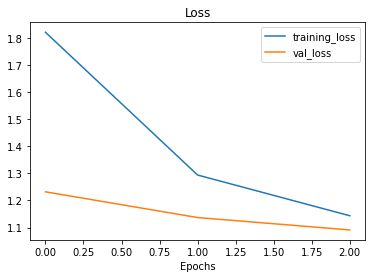

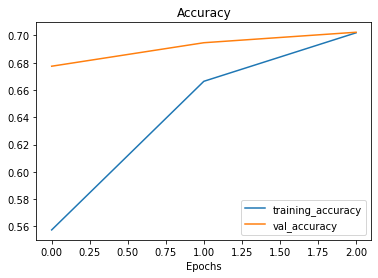

In [ ]:
plot_loss_curves(h1_FE)

## Preparing model for fine tuning

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in m1_feature_extractor.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

## Set up callbacks for fine tuning model


## Model 2-Fine Tuning 50% of layers of the base model

Build and Compile Fine Tuner with 50% layers still frozen

In [ ]:
# Model 2
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
m2_fine_tuner_50 = tf.keras.Model(inputs, outputs)

# Unfreeze 50% of base model
base_50_FT = -int(len(base_model.layers)/2)
for layer in base_model.layers[:base_50_FT]:
  layer.trainable = True

# Compile the model
m2_fine_tuner_50.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
h2_FT_50 = m2_fine_tuner_50.fit(train_data,
                       epochs=3,
                       steps_per_epoch=(len(train_data)),
                       validation_data = test_data,
                       validation_steps =int(0.15 * len(test_data))) # reduce the learning rate after X epochs of no improvements

Epoch 1/3
2368/2368 [==============================] - 180s 73ms/step - loss: 1.8215 - accuracy: 0.5579 - val_loss: 1.2364 - val_accuracy: 0.6782
Epoch 2/3
2368/2368 [==============================] - 169s 71ms/step - loss: 1.2930 - accuracy: 0.6668 - val_loss: 1.1299 - val_accuracy: 0.7029
Epoch 3/3
2368/2368 [==============================] - 169s 71ms/step - loss: 1.1434 - accuracy: 0.7024 - val_loss: 1.0902 - val_accuracy: 0.7087


In [ ]:
result_2 =  m2_fine_tuner_50.evaluate(test_data)
result_2

790/790 [==============================] - 49s 62ms/step - loss: 1.0900 - accuracy: 0.7067


[1.0900232791900635, 0.7066930532455444]

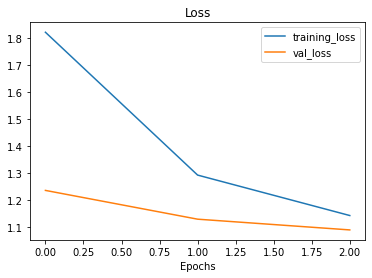

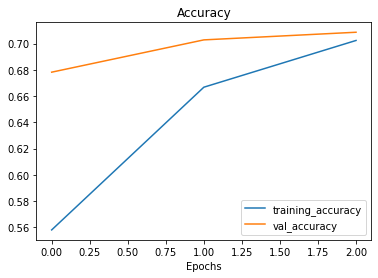

In [ ]:
plot_loss_curves(h2_FT_50)

##Model 3 (100% Fine Tuned)

In [ ]:
# Model 3
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
m3_fine_tuner = tf.keras.Model(inputs, outputs)

# Unfreeze all the layers of base model
for layer in base_model.layers:
  layer.trainable = True


# Compile the model
m3_fine_tuner.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
h3_FT = m3_fine_tuner.fit(train_data,
                       epochs=3,
                       steps_per_epoch=(len(train_data)),
                       validation_data = test_data,
                       validation_steps =int(0.15 * len(test_data)))

Epoch 1/3
2368/2368 [==============================] - 176s 74ms/step - loss: 1.5743 - accuracy: 0.6052 - val_loss: 1.2114 - val_accuracy: 0.6774
Epoch 2/3
2368/2368 [==============================] - 173s 72ms/step - loss: 1.2588 - accuracy: 0.6745 - val_loss: 1.1216 - val_accuracy: 0.7005
Epoch 3/3
2368/2368 [==============================] - 174s 73ms/step - loss: 1.1233 - accuracy: 0.7068 - val_loss: 1.0842 - val_accuracy: 0.7052


In [ ]:
result_3 =  m3_fine_tuner.evaluate(test_data)
result_3

790/790 [==============================] - 51s 65ms/step - loss: 1.0834 - accuracy: 0.7065


[1.0834169387817383, 0.7064950466156006]

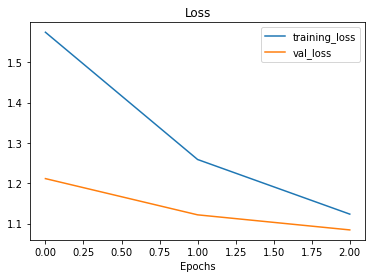

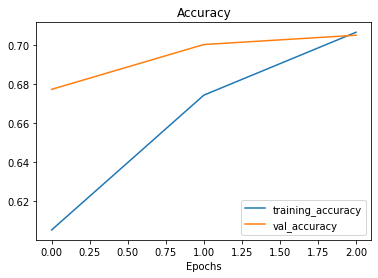

In [ ]:
plot_loss_curves(h3_FT)

## Model 4 (Final Model)

In [ ]:
# Turn on mixed precision training

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

In [ ]:
# Model 4
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
m4_fine_tuner = tf.keras.Model(inputs, outputs)

# Unfreeze all the layers of base model
for layer in base_model.layers:
  layer.trainable = True

# Compile the model
m4_fine_tuner.compile(loss="sparse_categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [ ]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss")

# Model Check Point
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")
# Learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
import os
# Saving model to Google Drive
# # Create save path to drive
save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"

# # Save model
m4_fine_tuner.save(save_dir)

In [ ]:
# Upload experiment results to TensorBoard
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=jGiMKklyNSdIXXPD1iyXNLlmAjMn9w&prompt=consent&access_type=offli

:## Manually Predicting Images using our model